# Exploratory Data Analysis

In [1]:
import json
import requests
import pandas as pd
import numpy as np
import time
import threading
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [2]:
#first we must retrieve the dataset we have created

ygo = pd.read_csv("../DataCollection/ygocardsbase.csv")

In [3]:
ygo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    11094 non-null  object 
 1   kind                    11094 non-null  object 
 2   attribute               11094 non-null  object 
 3   type                    11094 non-null  object 
 4   level                   6916 non-null   float64
 5   card_text               11094 non-null  object 
 6   effect_or_flavour_text  11094 non-null  float64
 7   attack                  7248 non-null   float64
 8   defence                 6916 non-null   float64
 9   pendulum_scale          278 non-null    float64
 10  link_rating             332 non-null    float64
 11  link_markers            332 non-null    object 
 12  printings               11094 non-null  float64
 13  sets                    11094 non-null  object 
 14  set_codes               11094 non-null

In [4]:
ygo = ygo.drop(['pendulum_scale','link_rating','link_markers'], axis=1)

#all three of these columns are for niche elements that will not be particularly useful outside of the master database so 
#now is a good time to drop them

In [6]:
ygo.release_date = pd.to_datetime(ygo.release_date)

#we need to convert the dates back into date format after they've been stored in a csv file

In [7]:
ygo.info()

#from here we should draw up a plan of action for every feature

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    11094 non-null  object        
 1   kind                    11094 non-null  object        
 2   attribute               11094 non-null  object        
 3   type                    11094 non-null  object        
 4   level                   6916 non-null   float64       
 5   card_text               11094 non-null  object        
 6   effect_or_flavour_text  11094 non-null  float64       
 7   attack                  7248 non-null   float64       
 8   defence                 6916 non-null   float64       
 9   printings               11094 non-null  float64       
 10  sets                    11094 non-null  object        
 11  set_codes               11094 non-null  object        
 12  set_rarities            11094 non-null  object

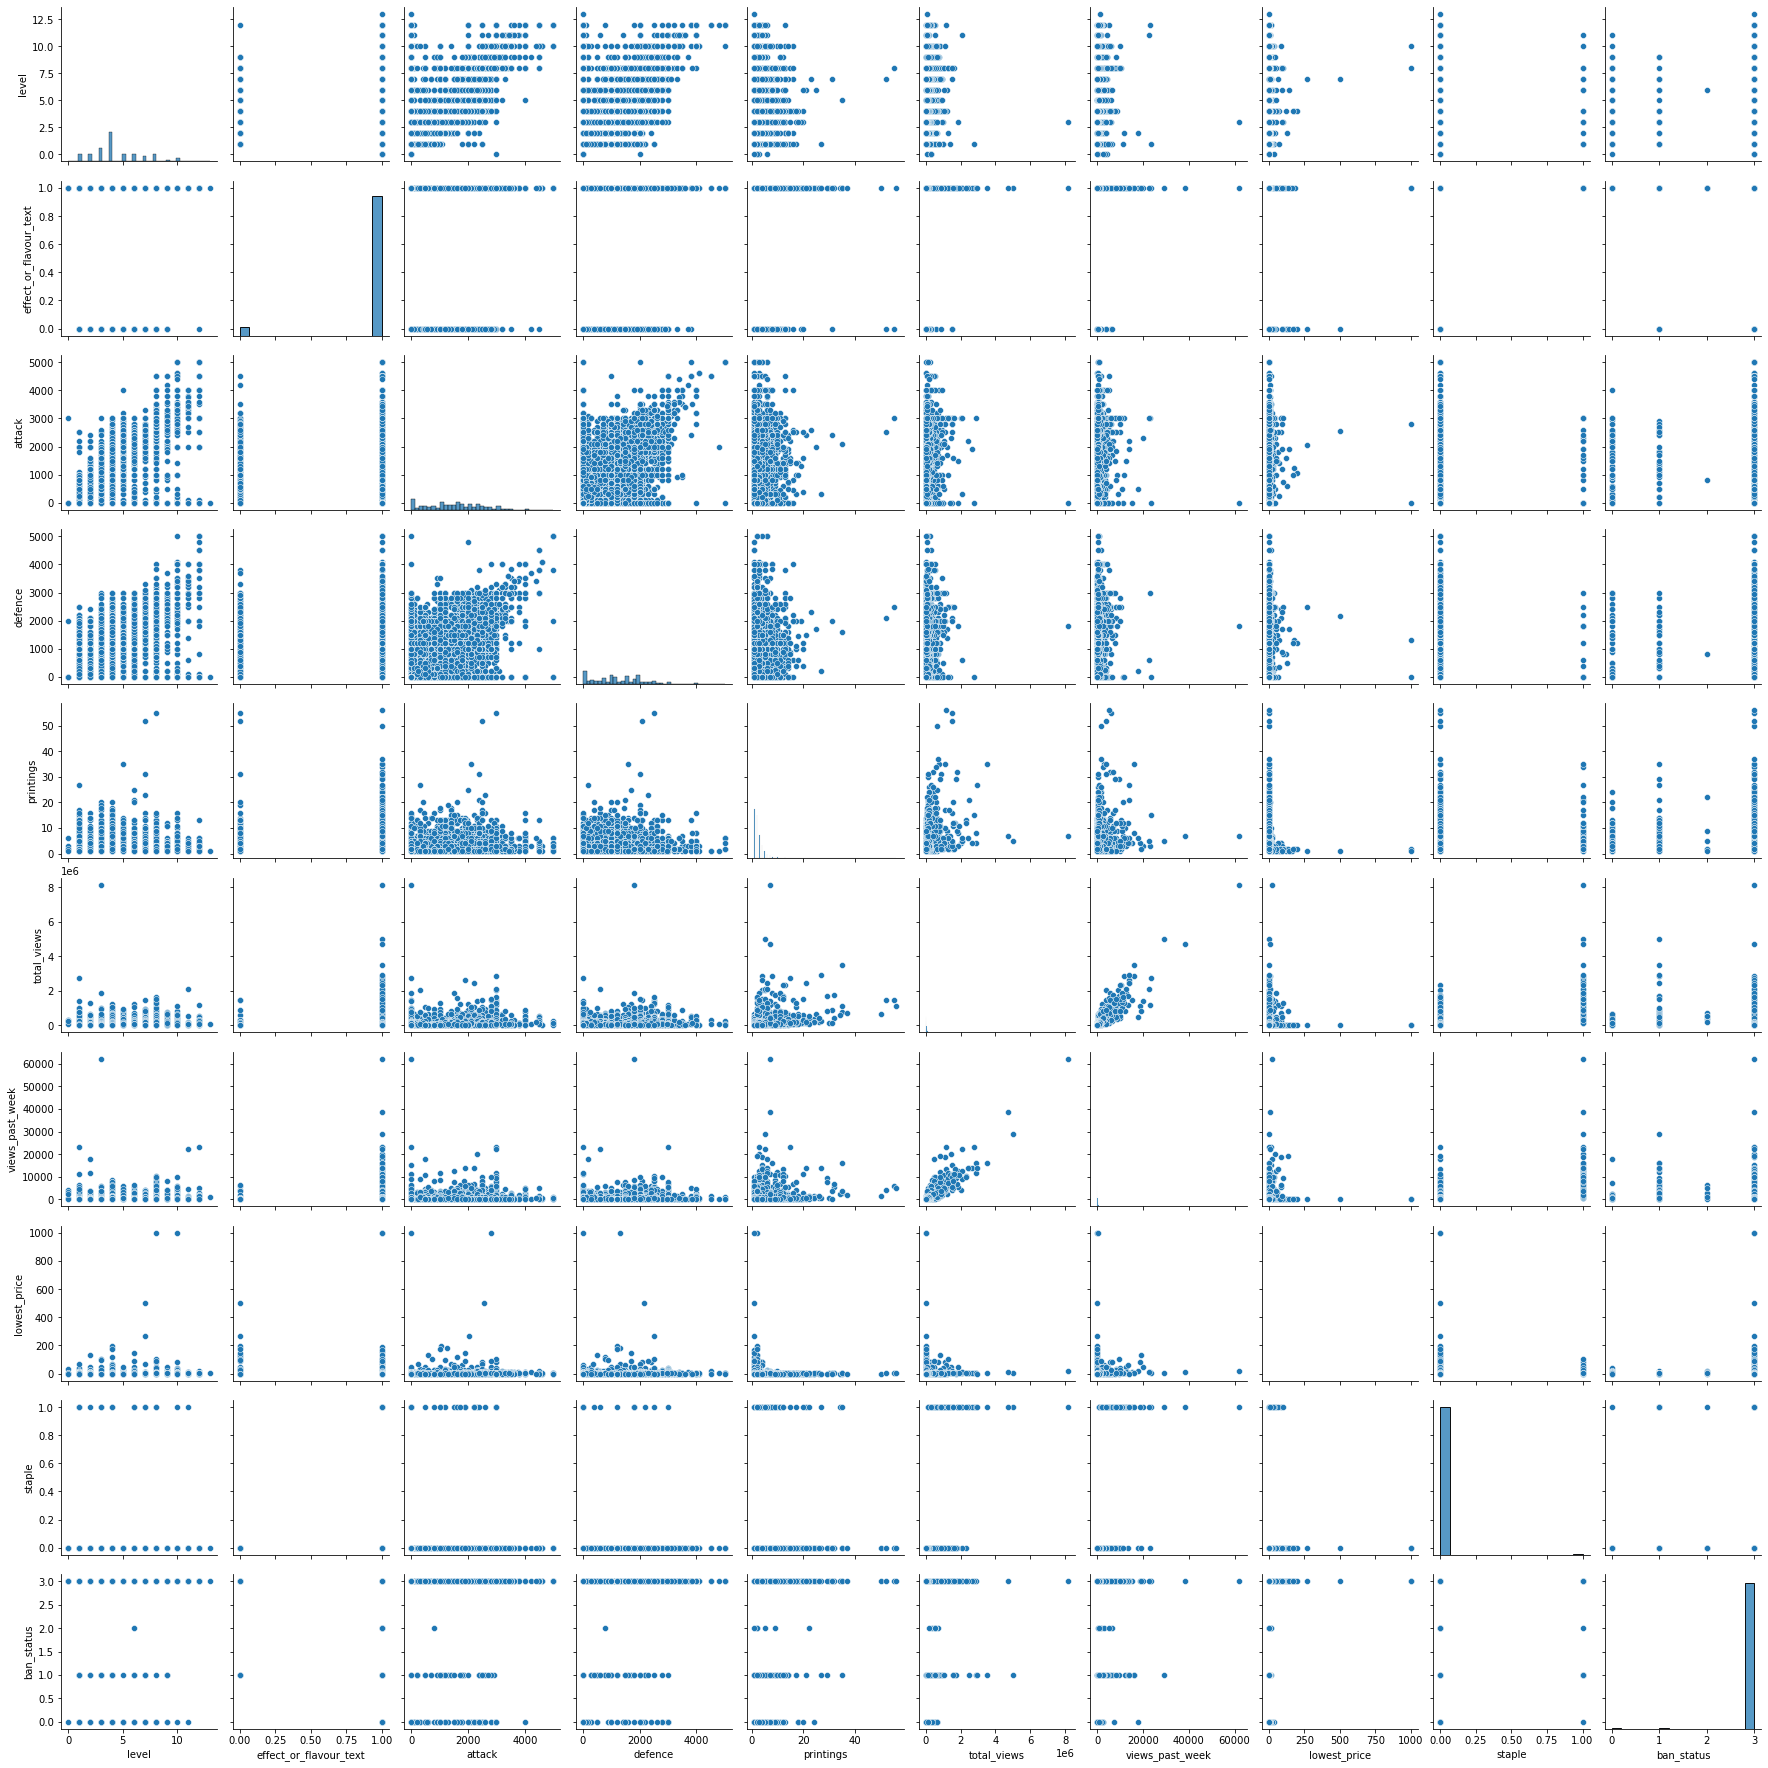

In [9]:
sns.pairplot(ygo)

#this just gives an easy overview from which we can try and identify any interesting relationships between features to 
#investigate further
#early indications suggest that we may have to deal with the multicollinearity between total views and views in the past 
#week, otherwise the dataset is dominated by categorical variables
#NB that for some of these such as views there are too many unique and varied values to make a good histogram

## Investigating the Target Variable

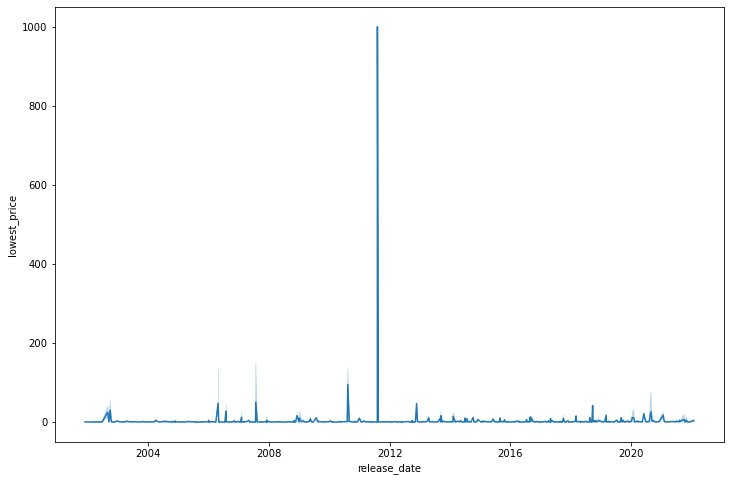

In [10]:
plt.figure(figsize=(12,8))
sns.lineplot(data = ygo, x = 'release_date', y = 'lowest_price');

#it looks like we potentially have an outlier here but having researched the specific card it makes sense why its value is 
#so high (it was given as a tournament prize and thus is very unique), however in order to get the best results from our 
#model it is likely we will need to remove it because it is so egregious compared to the rest of the dataset
#NB that because cards are released in sets, many share release dates and thus this graph mainly serves to highlight 
#anything that might be anomalous or an outlier

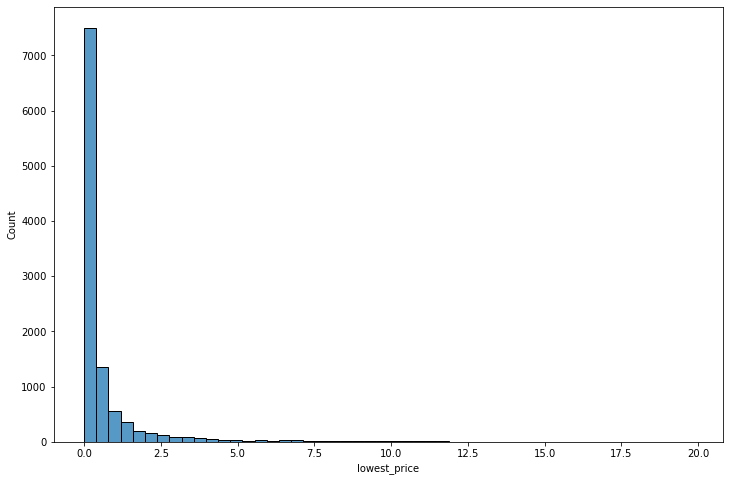

In [11]:
plt.figure(figsize=(12,8))
sns.histplot(data = ygo[ygo.lowest_price <= 20]['lowest_price'], bins=50);

#the data is extremely skewed even when applying a price mask like this, as a result it might be worth considering 
#techniques such as resampling to produce a normally distributed target variable instead

In [12]:
print(ygo[ygo.lowest_price <= 20].shape)

#there are only 100 cards with a price higher than $20 in our dataset, ideally we would have better pricing data to use for
#analysis instead but for now we will use this mask for analysing the data (it may be interesting at a later date to see 
#what results can be obtained using all the data)

price_mask = ygo.lowest_price <= 20

(10994, 20)


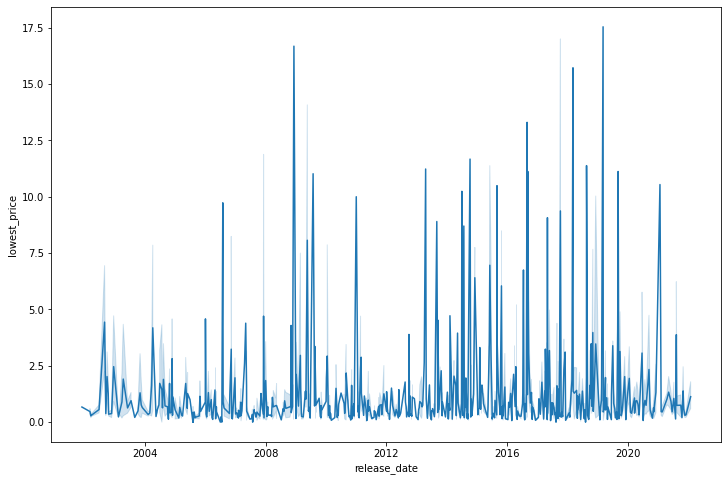

In [13]:
plt.figure(figsize=(12,8))
sns.lineplot(data = ygo[price_mask], x = 'release_date', y = 'lowest_price');

#we can see the mask makes the data a lot more interesting to look at over time with it seeming that there have been more 
#cards of higher value printed more recently

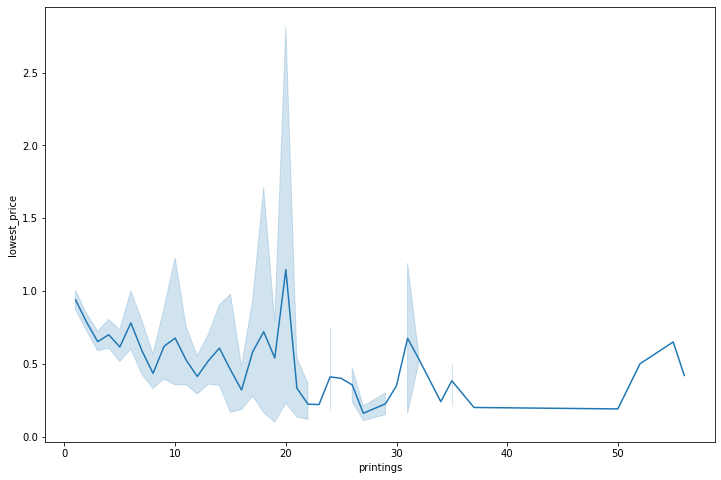

In [14]:
plt.figure(figsize=(12,8))
sns.lineplot(data = ygo[price_mask], x = 'printings', y = 'lowest_price');

#the data gets erratic as the number of printings gets higher due to the lack of data points being drawn upon, however there
#is a general negative trend which makes sense as scarcity should increase prices
#NB again this is another line plot that slightly breaks the rules (just as the ones above) due to there being multiple 
#cards that share a number of printings, however the overall shape of the graph is still interesting to see

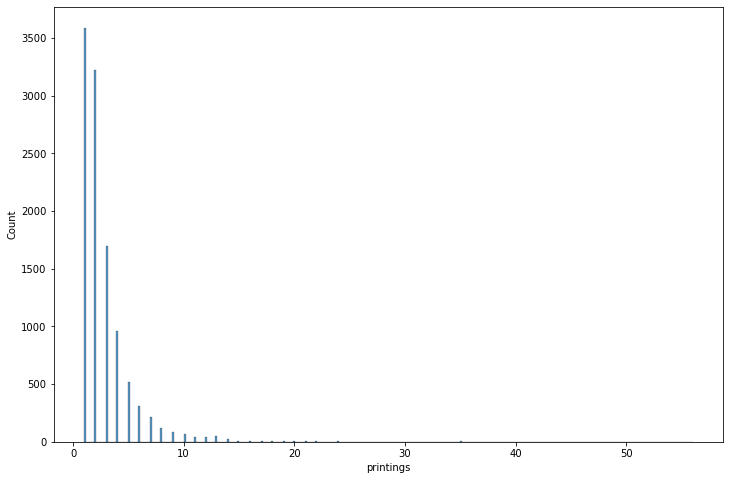

In [15]:
plt.figure(figsize=(12,8))
sns.histplot(data = ygo[price_mask]['printings']);

#we can easily see here how the number of printings rapidly decreases in frequency as implied by the graph above

## Investigating Features and Managing Them

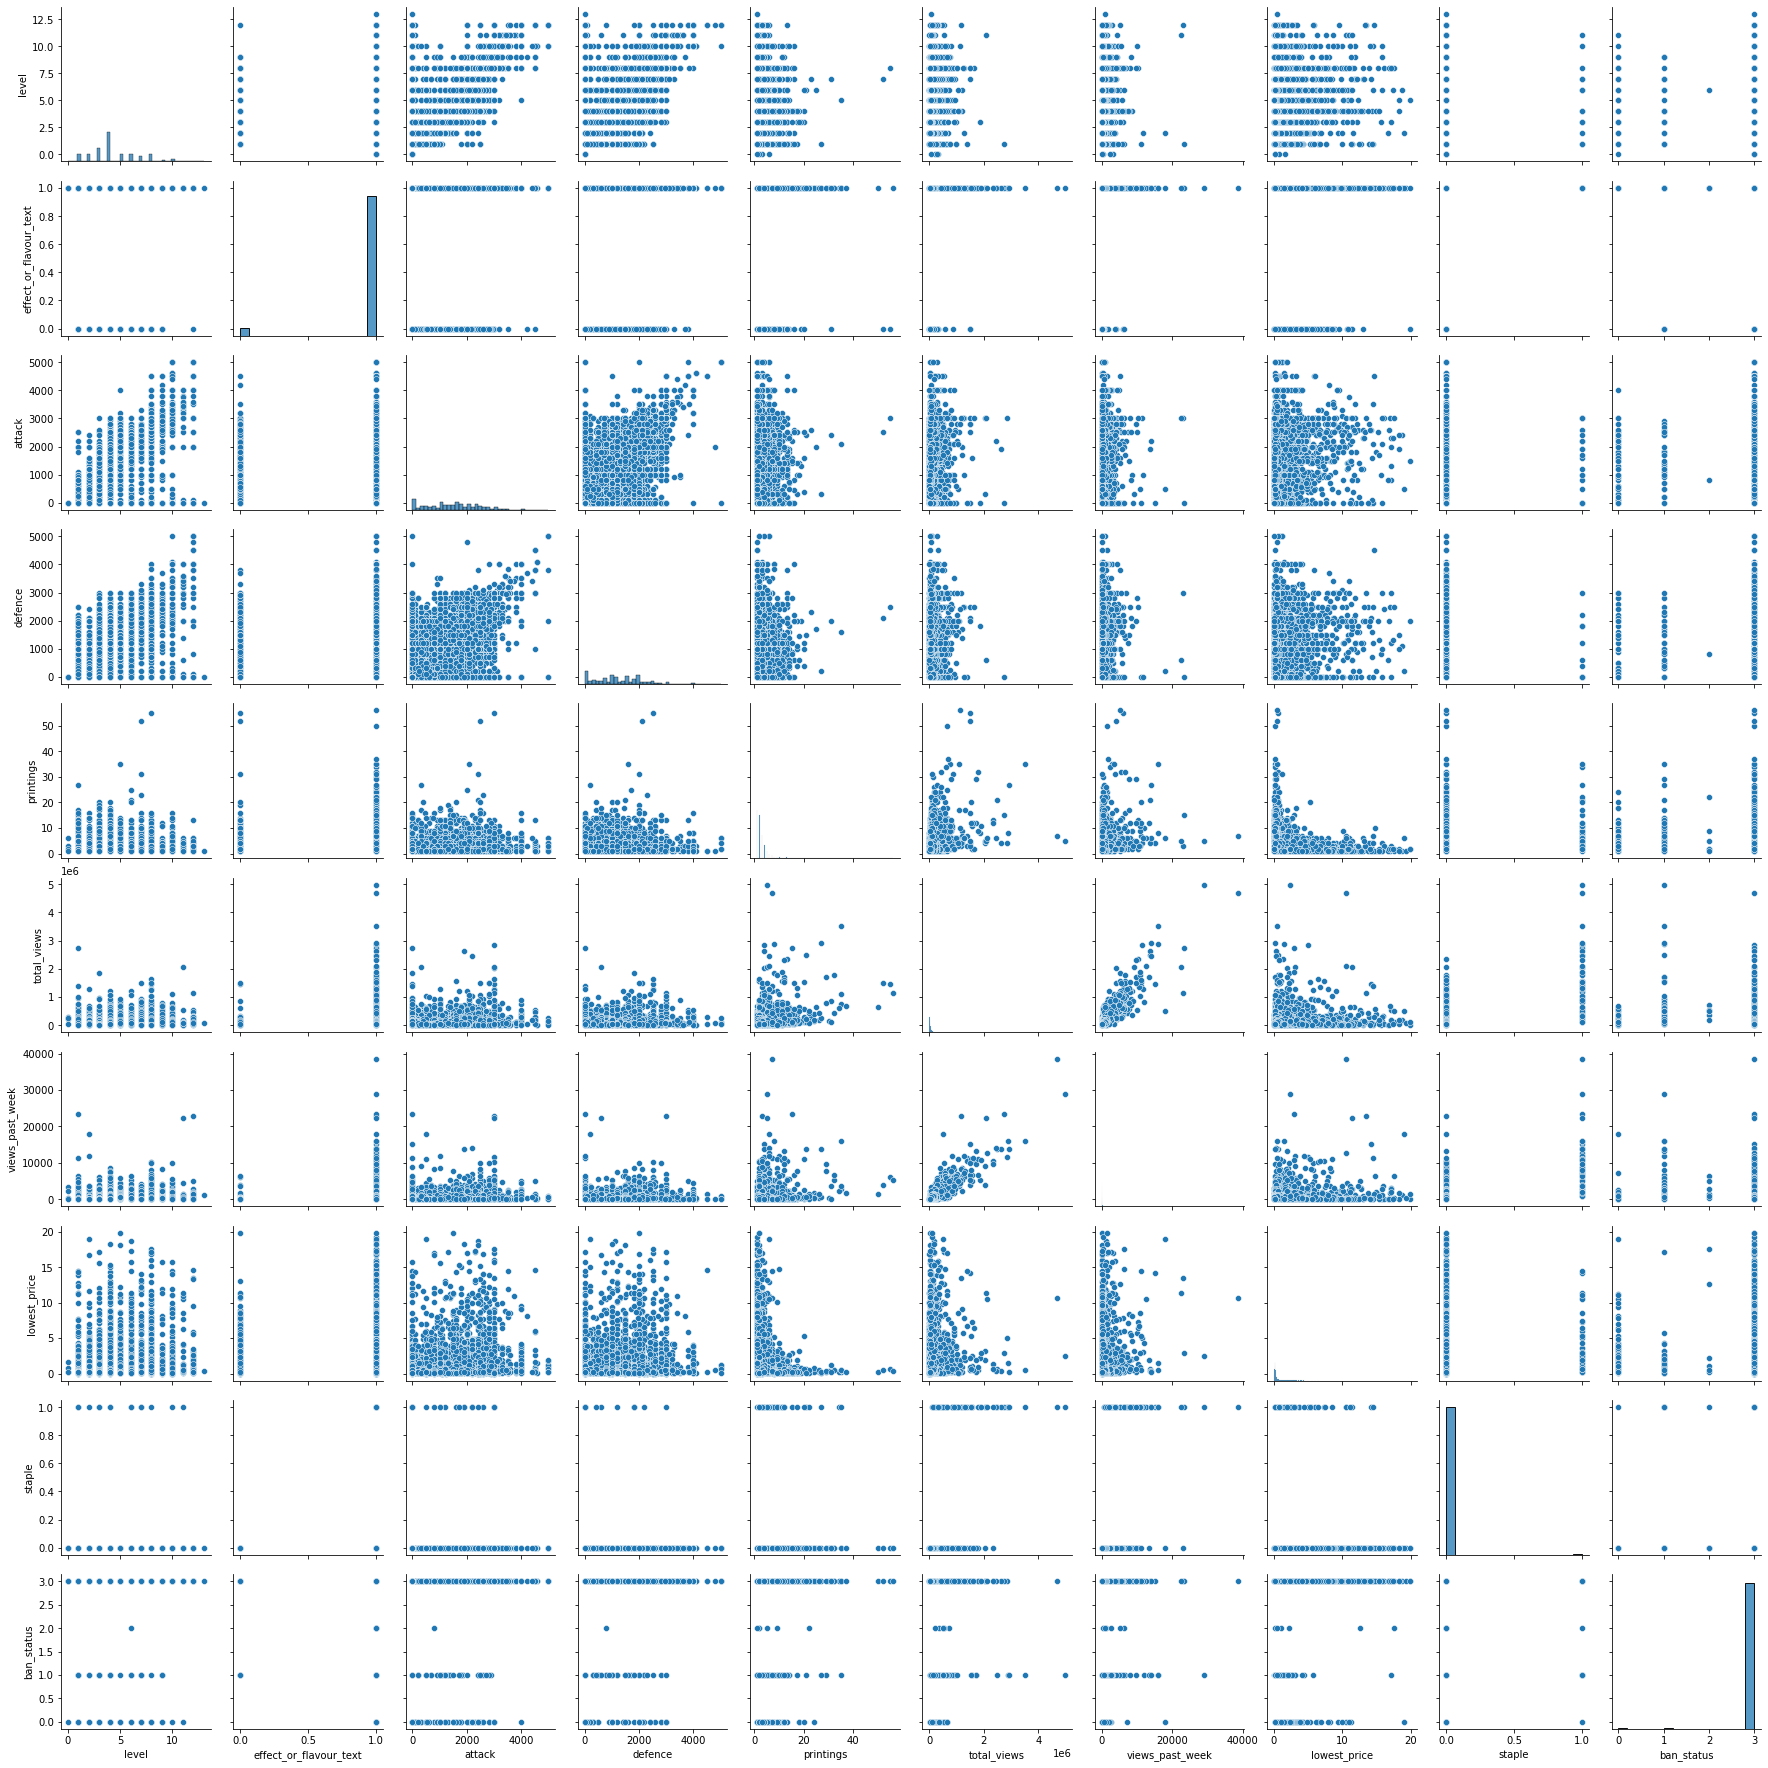

In [16]:
sns.pairplot(ygo[price_mask])

#we can now recheck the pair plots with the mask as well, although the relationships remain almost exactly the same

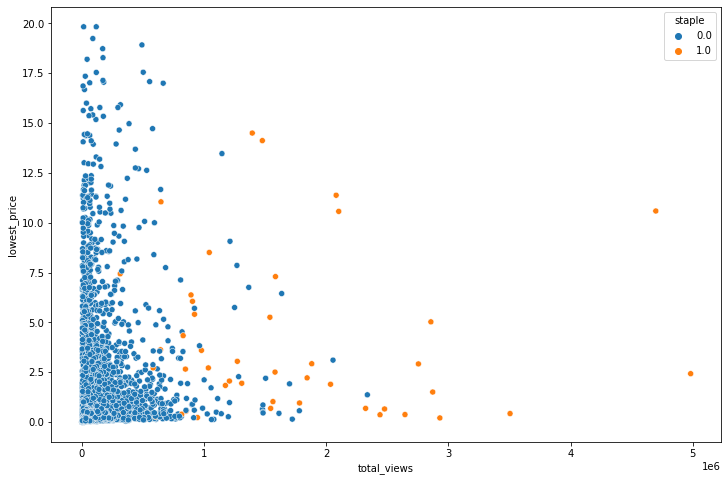

In [17]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = ygo[price_mask], x = 'total_views', y = 'lowest_price', hue = 'staple');

#this graph and the one below do help to visualise the effect of staple status on card price which seems relatively minor
#but correlated with viewing numbers, the graphs also highlight the correlation between total views and views in the past
#week

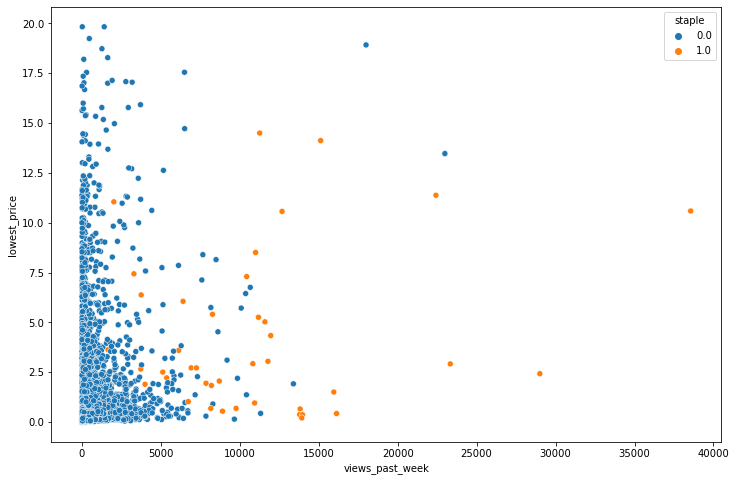

In [18]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = ygo[price_mask], x = 'views_past_week', y = 'lowest_price', hue = 'staple');

In [19]:
ygo[['total_views','views_past_week','lowest_price']].corr()

#we should probably drop one of the two views columns due to their correlation and it should probably be the total views as 
#the correlation with price is even lower and the information offered by the two features is extremely similar

total_views  views_past_week  lowest_price
total_views         1.000000         0.890588      0.041135
views_past_week     0.890588         1.000000      0.071166
lowest_price        0.041135         0.071166      1.000000

In [20]:
ygo.drop('total_views',axis=1,inplace=True)

In [21]:
ygo.kind.value_counts()

#fundamentally there are too many different categories in this column and in particular too many that have very small 
#populations so we want to either drop this column or simplify it
#having investigated online about the feature and looking at the data we already have from our other columns it seems 
#logical to try simplifying this column to cards that belong in the main deck and cards that belong in the extra deck

Effect Monster                     4138
Spell Card                         2168
Trap Card                          1678
Normal Monster                      494
XYZ Monster                         446
Tuner Monster                       385
Fusion Monster                      374
Synchro Monster                     352
Link Monster                        332
Pendulum Effect Monster             219
Flip Effect Monster                 173
Ritual Effect Monster                91
Gemini Monster                       44
Union Effect Monster                 36
Pendulum Normal Monster              36
Spirit Monster                       31
Synchro Tuner Monster                22
Toon Monster                         17
Ritual Monster                       15
Normal Tuner Monster                 10
Token                                10
Pendulum Tuner Effect Monster         8
Pendulum Effect Fusion Monster        6
XYZ Pendulum Effect Monster           5
Synchro Pendulum Effect Monster       3


In [22]:
main_deck = ['Effect Monster','Spell Card','Trap Card','Normal Monster','Tuner Monster','Pendulum Effect Monster',
            'Flip Effect Monster','Ritual Effect Monster','Gemini Monster','Union Effect Monster','Pendulum Normal Monster',
            'Spirit Monster','Toon Monster','Ritual Monster','Normal Tuner Monster','Pendulum Tuner Effect Monster',
            'Pendulum Flip Effect Monster']
extra_deck = []

for i in ygo.kind:
    if i in main_deck:
        extra_deck.append(0)
    else:
        extra_deck.append(1)

ygo['extra'] = extra_deck

#1 indicates a card that starts a match in the extra deck and 0 a card that starts in the main deck and this simplifies this
#feature a great deal

In [23]:
#as a result of the above we can also delete the kind column

ygo.drop('kind',axis=1,inplace=True)

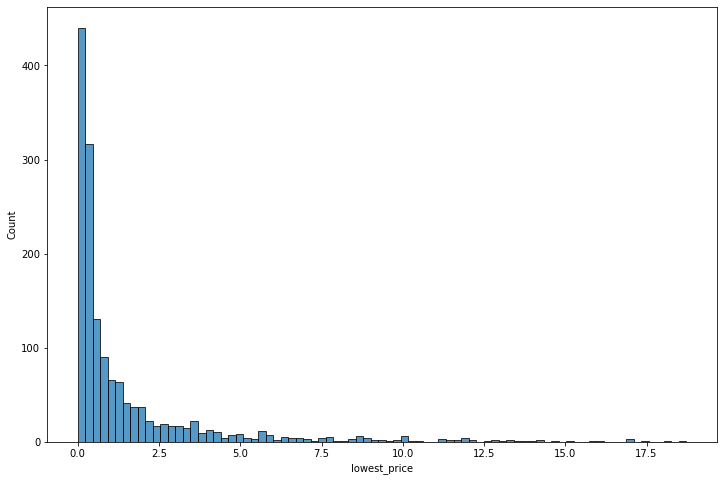

In [24]:
plt.figure(figsize=(12,8))
sns.histplot(ygo[price_mask & ygo.extra == 1]['lowest_price']);

#for some reason the graphic for the main deck cards doesn't want to work in this notebook but based on it working in other
#notebooks, it seems reasonable to say that extra deck cards are slightly more valuable than main deck ones

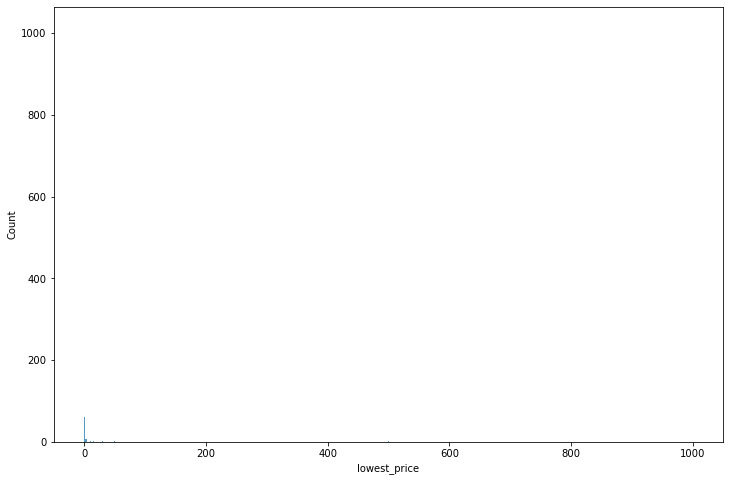

In [25]:
plt.figure(figsize=(12,8))
sns.histplot(ygo[price_mask & ygo.extra == 0]['lowest_price']);

#not sure why the above works and this one doesn't want to in this notebook

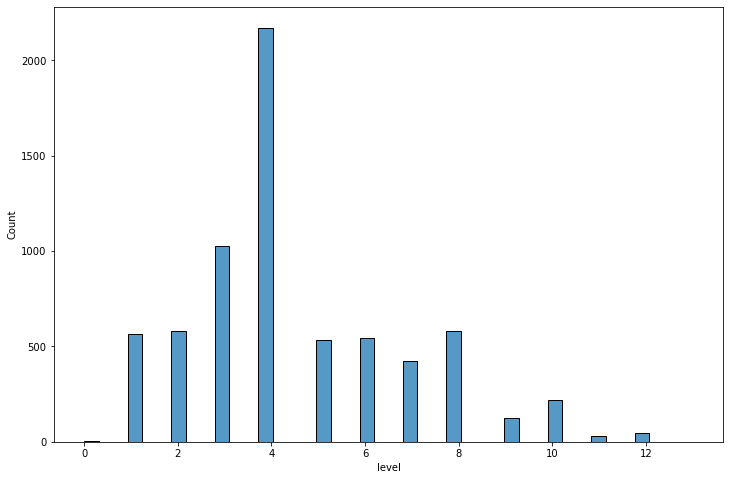

In [26]:
plt.figure(figsize=(12,8))
sns.histplot(ygo[price_mask]['level']);

#while there is an argument for dummifying level it can also reasonably be treated as purely numeric

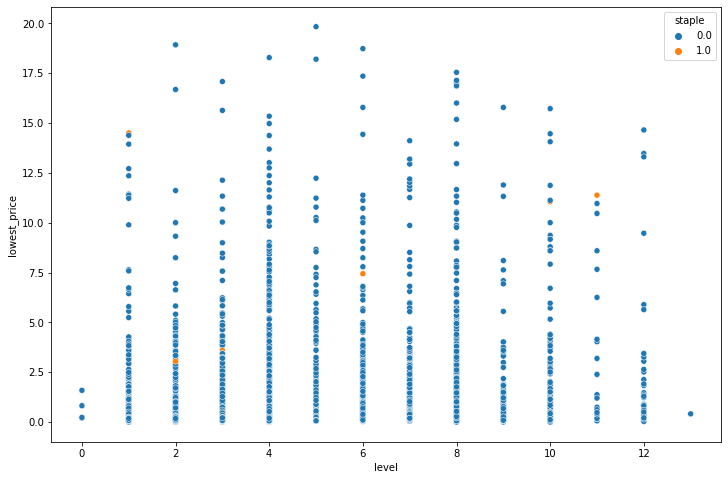

In [27]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = ygo[price_mask], x = 'level', y = 'lowest_price', hue = 'staple');

#it is worth noting that many cards do not have a level so based on the lack of interesting data here it may be worth
#dropping the column entirely

In [28]:
pd.get_dummies(ygo,columns=['attribute'])[['attribute_DARK', 'attribute_DIVINE',
                                           'attribute_EARTH', 'attribute_FIRE', 
                                           'attribute_LIGHT','attribute_SPELL', 
                                           'attribute_TRAP', 'attribute_WATER',
                                           'attribute_WIND','lowest_price']].corr()

#we will have to dummify the attribute column to use it later, fortunately it seems that it does not suffer from 
#multicollinearity

attribute_DARK  attribute_DIVINE  attribute_EARTH  \
attribute_DARK          1.000000         -0.009909        -0.198730   
attribute_DIVINE       -0.009909          1.000000        -0.009043   
attribute_EARTH        -0.198730         -0.009043         1.000000   
attribute_FIRE         -0.113831         -0.005180        -0.103873   
attribute_LIGHT        -0.184099         -0.008377        -0.167993   
attribute_SPELL        -0.229992         -0.010465        -0.209871   
attribute_TRAP         -0.197004         -0.008964        -0.179769   
attribute_WATER        -0.123945         -0.005640        -0.113101   
attribute_WIND         -0.121844         -0.005544        -0.111184   
lowest_price            0.039564          0.002583        -0.003031   

                  attribute_FIRE  attribute_LIGHT  attribute_SPELL  \
attribute_DARK         -0.113831        -0.184099        -0.229992   
attribute_DIVINE       -0.005180        -0.008377        -0.010465   
attribute_EARTH        -0.103873        -0.167993        -0.209871   
attribute_FIRE          1.000000        -0.096225        -0.120213   
attribute_LIGHT        -0.096225         1.000000        -0.194420   
attribute_SPELL        -0.120213        -0.194420         1.000000   
attribute_TRAP         -0.102970        -0.166534        -0.208048   
attribute_WATER        -0.064784        -0.104775        -0.130893   
attribute_WIND         -0.063686        -0.102999        -0.128675   
lowest_price           -0.009302        -0.000715        -0.002754   

                  attribute_TRAP  attribute_WATER  attribute_WIND  \
attribute_DARK         -0.197004        -0.123945       -0.121844   
attribute_DIVINE       -0.008964        -0.005640       -0.005544   
attribute_EARTH        -0.179769        -0.113101       -0.111184   
attribute_FIRE         -0.102970        -0.064784       -0.063686   
attribute_LIGHT        -0.166534        -0.104775       -0.102999   
attribute_SPELL        -0.208048        -0.130893       -0.128675   
attribute_TRAP          1.000000        -0.112119       -0.110219   
attribute_WATER        -0.112119         1.000000       -0.069344   
attribute_WIND         -0.110219        -0.069344        1.000000   
lowest_price           -0.026977        -0.003178       -0.000786   

                  lowest_price  
attribute_DARK        0.039564  
attribute_DIVINE      0.002583  
attribute_EARTH      -0.003031  
attribute_FIRE       -0.009302  
attribute_LIGHT      -0.000715  
attribute_SPELL      -0.002754  
attribute_TRAP       -0.026977  
attribute_WATER      -0.003178  
attribute_WIND       -0.000786  
lowest_price          1.000000

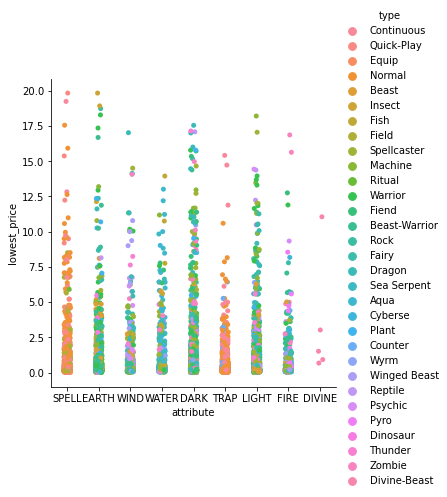

In [29]:
sns.catplot(data = ygo[price_mask], x = 'attribute', y = 'lowest_price', hue = 'type');

#this is a nice graph for visualising two key categorical elements of all cards before we dummify them, it gives a 
#demonstration of how many features there are to this dataset

In [30]:
ygo = pd.get_dummies(ygo,columns=['attribute'])

In [31]:
pd.get_dummies(ygo,columns=['type'])[['lowest_price','type_Aqua', 'type_Beast', 'type_Beast-Warrior',
       'type_Continuous', 'type_Counter', 'type_Cyberse', 'type_Dinosaur',
       'type_Divine-Beast', 'type_Dragon', 'type_Equip', 'type_Fairy',
       'type_Field', 'type_Fiend', 'type_Fish', 'type_Insect', 'type_Machine',
       'type_Normal', 'type_Plant', 'type_Psychic', 'type_Pyro',
       'type_Quick-Play', 'type_Reptile', 'type_Ritual', 'type_Rock',
       'type_Sea Serpent', 'type_Spellcaster', 'type_Thunder', 'type_Warrior',
       'type_Winged Beast', 'type_Wyrm', 'type_Zombie']].corr()

#the correlation scenario for type is essentially the same as for attribute

lowest_price  type_Aqua  type_Beast  type_Beast-Warrior  \
lowest_price            1.000000  -0.003016    0.006066           -0.004542   
type_Aqua              -0.003016   1.000000   -0.024893           -0.020082   
type_Beast              0.006066  -0.024893    1.000000           -0.025660   
type_Beast-Warrior     -0.004542  -0.020082   -0.025660            1.000000   
type_Continuous        -0.013783  -0.039717   -0.050750           -0.040941   
type_Counter           -0.006662  -0.015893   -0.020308           -0.016383   
type_Cyberse           -0.006330  -0.019807   -0.025309           -0.020418   
type_Dinosaur          -0.005674  -0.013904   -0.017766           -0.014332   
type_Divine-Beast       0.002583  -0.002964   -0.003787           -0.003055   
type_Dragon             0.026034  -0.033609   -0.042945           -0.034645   
type_Equip              0.004168  -0.021193   -0.027080           -0.021846   
type_Fairy             -0.002549  -0.028432   -0.036330           -0.029308   
type_Field             -0.008518  -0.020887   -0.026689           -0.021531   
type_Fiend              0.022447  -0.036028   -0.046036           -0.037139   
type_Fish              -0.000739  -0.013839   -0.017683           -0.014266   
type_Insect            -0.000838  -0.019807   -0.025309           -0.020418   
type_Machine           -0.011758  -0.040461   -0.051701           -0.041708   
type_Normal            -0.014655  -0.064055   -0.081847           -0.066029   
type_Plant             -0.000103  -0.019294   -0.024653           -0.019888   
type_Psychic           -0.003810  -0.016884   -0.021574           -0.017405   
type_Pyro              -0.005772  -0.014534   -0.018571           -0.014982   
type_Quick-Play        -0.003905  -0.026322   -0.033634           -0.027133   
type_Reptile           -0.005263  -0.016669   -0.021299           -0.017183   
type_Ritual             0.006537  -0.011042   -0.014109           -0.011382   
type_Rock              -0.003468  -0.020082   -0.025660           -0.020701   
type_Sea Serpent       -0.002385  -0.011669   -0.014910           -0.012028   
type_Spellcaster        0.005119  -0.033609   -0.042945           -0.034645   
type_Thunder           -0.003868  -0.014348   -0.018333           -0.014790   
type_Warrior            0.022316  -0.042788   -0.054673           -0.044106   
type_Winged Beast       0.000179  -0.022908   -0.029271           -0.023614   
type_Wyrm              -0.000782  -0.012118   -0.015484           -0.012492   
type_Zombie             0.000038  -0.019388   -0.024773           -0.019985   

                    type_Continuous  type_Counter  type_Cyberse  \
lowest_price              -0.013783     -0.006662     -0.006330   
type_Aqua                 -0.039717     -0.015893     -0.019807   
type_Beast                -0.050750     -0.020308     -0.025309   
type_Beast-Warrior        -0.040941     -0.016383     -0.020418   
type_Continuous            1.000000     -0.032401     -0.040380   
type_Counter              -0.032401      1.000000     -0.016159   
type_Cyberse              -0.040380     -0.016159      1.000000   
type_Dinosaur             -0.028345     -0.011343     -0.014136   
type_Divine-Beast         -0.006042     -0.002418     -0.003013   
type_Dragon               -0.068519     -0.027419     -0.034171   
type_Equip                -0.043205     -0.017289     -0.021547   
type_Fairy                -0.057964     -0.023195     -0.028907   
type_Field                -0.042583     -0.017040     -0.021236   
type_Fiend                -0.073450     -0.029392     -0.036630   
type_Fish                 -0.028213     -0.011290     -0.014070   
type_Insect               -0.040380     -0.016159     -0.020138   
type_Machine              -0.082488     -0.033008     -0.041137   
type_Normal               -0.130587     -0.052256     -0.065124   
type_Plant                -0.039333     -0.015740     -0.019616   
type_Psychic              -0.034422     -0.013774     -0.017166   
type_

In [32]:
ygo = pd.get_dummies(ygo,columns=['type'])

In [33]:
#while there is a technical difference between cards with 0 attack and/or defence and cards that simply do not have a value
#for either, for our model it will be simplest to set the null values to 0 (although this will clutter graphs and impede
#some scalers), this is also the approach already taken in some cases by the original data source

ygo.attack = ygo.attack.replace({ np.nan: 0})
ygo.defence = ygo.defence.replace({ np.nan: 0})

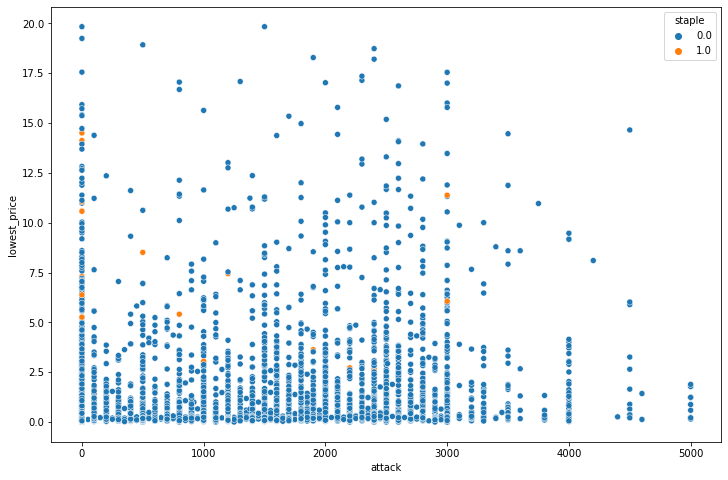

In [34]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = ygo[price_mask], x = 'attack', y = 'lowest_price', hue = 'staple');

#this graph for attack and the corresponding one below for defence suggest that they might not be that correlqted with the
#target variable but for now we will keep them both

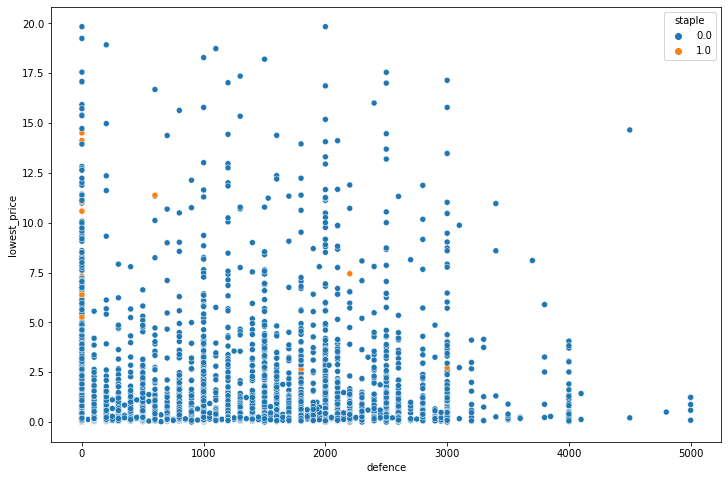

In [35]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = ygo[price_mask], x = 'defence', y = 'lowest_price', hue = 'staple');

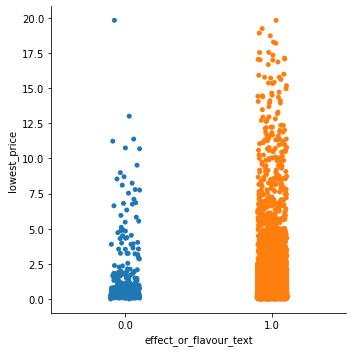

In [36]:
sns.catplot(data=ygo[price_mask],x='effect_or_flavour_text',y='lowest_price');

#unsurprisingly there are far more cards with effects that have higher values (in part because there are more effect cards
#than normal cards)

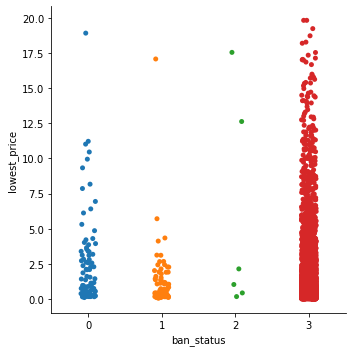

In [37]:
sns.catplot(data=ygo[price_mask],x='ban_status',y='lowest_price');

#the pricing of banned and limited cards is reflective of their power and the potential power they have if they come off the
#ban list, but naturally there are many more cards that are unlimited meaning that there are plenty of those with higher
#values

In [55]:
#having got this stage level still seems unlikely to be worth keeping so we'll drop it here (the other questionable 
#features will most likely stay)

ygo.drop('level',axis=1,inplace=True)

## Investigating Textual Features

In [38]:
ygo.info()

#at this point the majority of the features in the dataset have in some way been examined and so we move into some EDA for 
#the textual features name and card text

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 57 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    11094 non-null  object        
 1   level                   6916 non-null   float64       
 2   card_text               11094 non-null  object        
 3   effect_or_flavour_text  11094 non-null  float64       
 4   attack                  11094 non-null  float64       
 5   defence                 11094 non-null  float64       
 6   printings               11094 non-null  float64       
 7   sets                    11094 non-null  object        
 8   set_codes               11094 non-null  object        
 9   set_rarities            11094 non-null  object        
 10  rarity_codes            11094 non-null  object        
 11  views_past_week         11094 non-null  int64         
 12  lowest_price            11094 non-null  float6

In [39]:
#we import the packages suggested by the word cloud documentation to make sure it gets setup correctly

import os

In [40]:
import PIL

In [41]:
import wordcloud as wcloud

In [42]:
ygo.card_text[0]

#an example bit of card text to test with

'During each of your Standby Phases, put 1 A-Counter on 1 face-up monster your opponent controls.'

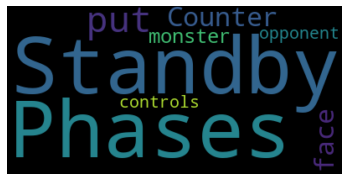

In [43]:
#testing word cloud with the text, also NB that word clouds can only handle ngrams up to 2

wordcloud = wcloud.WordCloud().generate(ygo.card_text[0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [44]:
#we can build a custom list of stopwords for the wordclouds but NB that the format of this must be a set so we use the .add
#function to add any additional entries
#many cards mention words such as card on themselves and phrases such as 'once per turn' but we are not interested in some
#of these because they do not differentiate the cards
#NB there is most likely a near endless amount of tweaking that could be done with these stopwords

stop = wcloud.STOPWORDS
stop.add('per')
stop.add('effect')
stop.add('card')


In [45]:
wcloud.STOPWORDS

#at a later date it may be a good idea to remove some of the stopwords such as 'up' and 'down' (some cards are placed
#face-up or face-down based on effects)

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'card',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'effect',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',

In [46]:
cloud_text = ''
for i in ygo.card_text:
    cloud_text+=i
    
#this sets up the card text ready for being turned into a word cloud

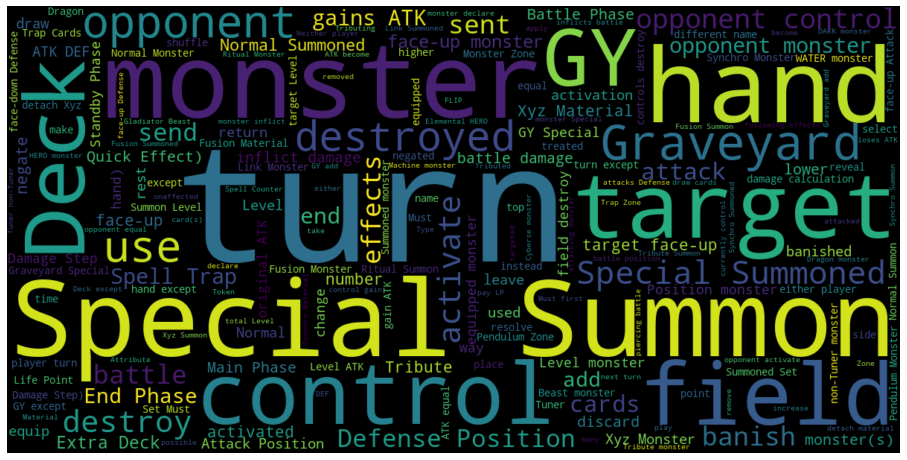

In [47]:
#width and height affect how granular the detail on the canvas is, meanwhile we use a custom bit of regex because cards in
#this game often use terms such as monster(s) and some cards have names including characters such as @, unfortunately there
#are probably a few that still slip through the net since it is far too time consuming to check ~11000 unique texts

wordcloud = wcloud.WordCloud(width=1200,height=600,regexp=r"\w[\w'()@-]+",stopwords=stop).generate(cloud_text)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [48]:
#we can also make a wordcloud from card names 

name_text = ''
for i in ygo.name:
    name_text+=i

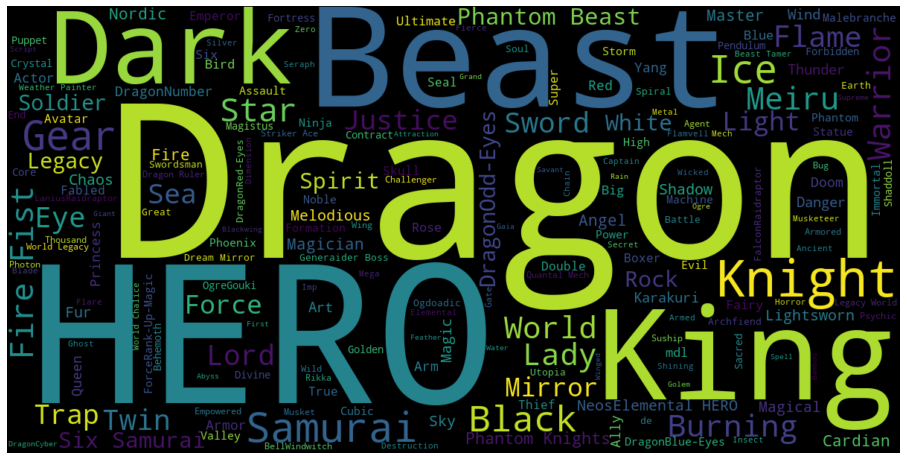

In [49]:
wordcloud = wcloud.WordCloud(width=1200,height=600,regexp=r"\w[\w'()@-]+").generate(name_text)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [50]:
ygo.columns

#using columns we can make specific word clouds for specific groups of cards

Index(['name', 'level', 'card_text', 'effect_or_flavour_text', 'attack',
       'defence', 'printings', 'sets', 'set_codes', 'set_rarities',
       'rarity_codes', 'views_past_week', 'lowest_price', 'release_date',
       'staple', 'ban_status', 'extra', 'attribute_DARK', 'attribute_DIVINE',
       'attribute_EARTH', 'attribute_FIRE', 'attribute_LIGHT',
       'attribute_SPELL', 'attribute_TRAP', 'attribute_WATER',
       'attribute_WIND', 'type_Aqua', 'type_Beast', 'type_Beast-Warrior',
       'type_Continuous', 'type_Counter', 'type_Cyberse', 'type_Dinosaur',
       'type_Divine-Beast', 'type_Dragon', 'type_Equip', 'type_Fairy',
       'type_Field', 'type_Fiend', 'type_Fish', 'type_Insect', 'type_Machine',
       'type_Normal', 'type_Plant', 'type_Psychic', 'type_Pyro',
       'type_Quick-Play', 'type_Reptile', 'type_Ritual', 'type_Rock',
       'type_Sea Serpent', 'type_Spellcaster', 'type_Thunder', 'type_Warrior',
       'type_Winged Beast', 'type_Wyrm', 'type_Zombie'],
      dtype

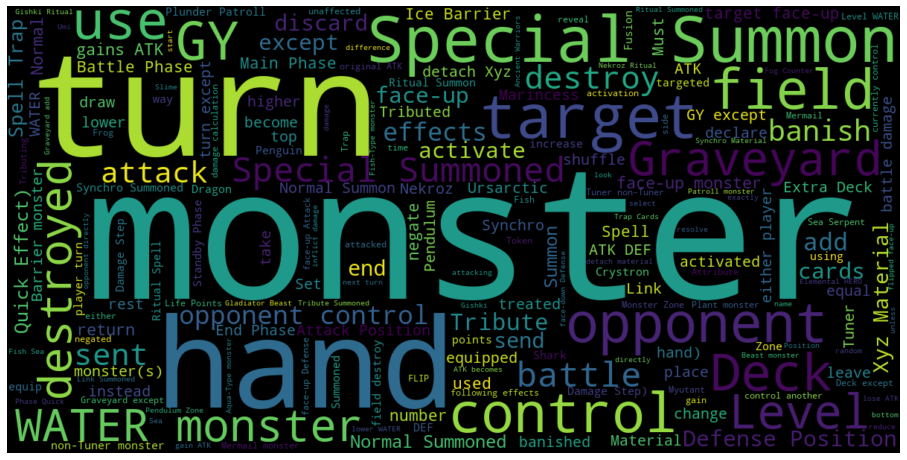

In [51]:
#this and the following cell allow for looking at subsets of the data's name and card text

subset_text = ''
for i in ygo[ygo.attribute_WATER==1].card_text:
    subset_text+=i
wordcloud = wcloud.WordCloud(width=1200,height=600,regexp=r"\w[\w'()@-]+",stopwords=stop).generate(subset_text)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

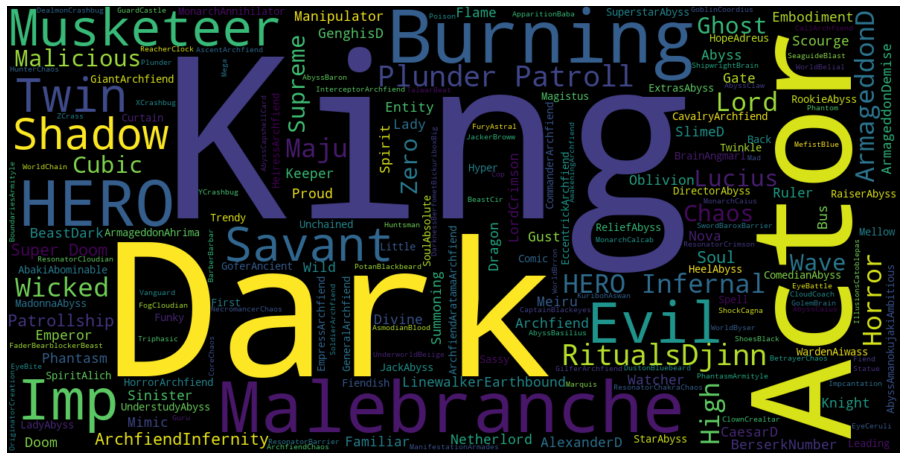

In [52]:
subset_name = ''
for i in ygo[ygo.type_Fiend==1].name:
    subset_name+=i
wordcloud = wcloud.WordCloud(width=1200,height=600,regexp=r"\w[\w'()@-]+").generate(subset_name)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Handling the Issue Identified in the Acquisition Process

In [54]:
#probably the most complex and hardest part of the EDA concerns the 4 columns 'sets', 'set_codes', 'set_rarities',
#'rarity_codes', I have left these until the end since any new pricing data would most likely be joined with the base 
#dataset using these columns since all the set codes identify every individual printing of each unique card along with its
#corresponding rarity
#as a result the sets column is droppable straightaway

ygo.drop('sets',axis=1,inplace=True)

For the 3 remaining columns to deal with we will assume that since our current pricing data is the lowest price the card is available at, the price must be for the lowest rarity printing of that card and thus be for the related set code as well. 

In [57]:
#first in order to act on this we must transform the columns back into the lists they originally were
#NB that we will also be able to condense the rarity_codes and set_rarities columns into one
#the following cells all transform the data back into the original list format

ygo['set_codes'] = [x.strip("[]").split(',') for x in ygo.set_codes]
completefixes = []
for i in ygo.set_codes:
    fixed =[]
    for x in i:
        fixed.append(x.strip("'' "))
    completefixes.append(fixed)
print(completefixes)
ygo['set_codes'] = completefixes

[['FOTB-EN043'], ['GLAS-EN062'], ['INOV-EN063'], ['STON-EN041'], ['MP21-EN136', 'ROTD-EN053'], ['MP21-EN137', 'ROTD-EN054'], ['MP21-EN138', 'ROTD-EN055'], ['MP15-EN169', 'NECH-EN059', 'NECH-ENS10'], ['AST-070', 'DR2-EN183'], ['DB1-EN198', 'PSV-088', 'PSV-E088', 'PSV-EN088', 'RP02-EN022', 'YSYR-EN010'], ['AST-091', 'DR2-EN204'], ['GLD1-EN001', 'MRD-098', 'MRD-E098', 'MRD-EN098', 'SDJ-008', 'SD4-EN002'], ['BP03-EN135', 'BP03-EN135', 'DT02-EN038', 'PSV-004', 'PSV-E004', 'PSV-EN004', 'SBSC-EN029'], ['GLD1-EN007', 'PGD-024'], ['DR1-EN018', 'PGD-070', 'SS01-ENB11'], ['DCR-030', 'DCR-EN030', 'DR1-EN192', 'LCJW-EN241'], ['CP03-EN018', 'DR3-EN157', 'FET-EN037', 'FET-EN037', 'LCYW-EN280', 'LEHD-ENA26', 'YSDS-EN029'], ['LOD-032', 'LOD-EN032'], ['BP02-EN179', 'BP02-EN179', 'DR2-EN105', 'DT02-EN048', 'DP1-EN025', 'IOC-104', 'IOC-EN104', 'YS14-EN036'], ['DUSA-EN087', 'GENF-EN098', 'GENF-EN098', 'SDHS-EN026', 'LED6-EN022'], ['DB2-EN187', 'HL1-EN003', 'LOD-078', 'LOD-EN078', 'LEDU-EN021', 'LDS1-EN029'

In [58]:
ygo['set_rarities'] = [x.strip("[]").split(',') for x in ygo.set_rarities]
completefixes = []
for i in ygo.set_rarities:
    fixed =[]
    for x in i:
        fixed.append(x.strip("'' "))
    completefixes.append(fixed)
print(completefixes)
ygo['set_rarities'] = completefixes

[['Common'], ['Common'], ['Common'], ['Common'], ['Super Rare', 'Ultra Rare'], ['Super Rare', 'Common'], ['Super Rare', 'Super Rare'], ['Super Rare', 'Super Rare', 'Super Rare'], ['Common', 'Common'], ['Common', 'Common', 'Common', 'Common', 'Common', 'Common'], ['Short Print', 'Common'], ['Common', 'Common', 'Common', 'Common', 'Common', 'Common'], ['Common', 'Shatterfoil Rare', 'Duel Terminal Normal Parallel Rare', 'Common', 'Common', 'Common', 'Common'], ['Common', 'Common'], ['Common', 'Common', 'Common'], ['Common', 'Common', 'Common', 'Rare'], ['Common', 'Super Rare', 'Super Rare', 'Ultimate Rare', 'Secret Rare', 'Common', 'Common'], ['Common', 'Common'], ['Common', 'Mosaic Rare', 'Common', 'Duel Terminal Normal Parallel Rare', 'Common', 'Common', 'Common', 'Common'], ['Ultra Rare', 'Ultimate Rare', 'Ultra Rare', 'Common', 'Common'], ['Common', 'Common', 'Common', 'Common', 'Common', 'Common', 'Common', 'Common', 'Common'], ['Short Print', 'Common'], ['Common', 'Common'], ['Commo

In [59]:
ygo['rarity_codes'] = [x.strip("[]").split(',') for x in ygo.rarity_codes]
completefixes = []
for i in ygo.rarity_codes:
    fixed =[]
    for x in i:
        fixed.append(x.strip("'' "))
    completefixes.append(fixed)
print(completefixes)
ygo['rarity_codes'] = completefixes

[['(C)'], ['(C)'], ['(C)'], ['(C)'], ['(SR)', '(UR)'], ['(SR)', '(C)'], ['(SR)', '(SR)'], ['(SR)', '(SR)', '(SR)'], ['(C)', '(C)'], ['(C)', '(C)', '(C)', '(C)', '(C)', '(C)'], ['(SP)', '(C)'], ['(C)', '(C)', '(C)', '(C)', '(C)', '(C)'], ['(C)', '(SHR)', '(DNPR)', '(C)', '(C)', '(C)', '(C)'], ['(C)', '(C)'], ['(C)', '(C)', '(C)'], ['(C)', '(C)', '(C)', '(R)'], ['(C)', '(SR)', '(SR)', '(UtR)', '(ScR)', '(C)', '(C)'], ['(C)', '(C)'], ['(C)', '(MSR)', '(C)', '(DNPR)', '(C)', '(C)', '(C)', '(C)'], ['(UR)', '(UtR)', '(UR)', '(C)', '(C)'], ['(C)', '(C)', '(C)', '(C)', '(C)', '(C)', '(C)', '(C)', '(C)'], ['(SP)', '(C)'], ['(C)', '(C)'], ['(C)', '(C)'], ['(ScR)', '(R)', '(ScR)'], ['(C)', '(C)', '(C)', '(C)', '(C)', '(C)', '(C)'], ['(ScR)', '(SR)'], ['(R)', '(R)', '(UtR)'], ['(UR)'], ['(C)'], ['(UR)', '(SR)'], ['(C)', '(R)'], ['(C)'], ['(C)', '(C)'], ['(C)', '(C)'], ['(UR)'], ['(C)', '(R)'], ['(C)', '(C)'], ['(C)', '(C)', '(C)', '(C)'], ['(C)', '(C)'], ['(C)', '(C)'], ['(ScR)', '(SR)', '(SR)', '

In [60]:
ygo.explode('rarity_codes')

#we can use this function to expand out our dataframe based on each list column to first get an idea of what we are working 
#with, fortunately the size of the dataframe is consistent no matter which row we choose to expand around, at 31042 rows

name  \
0           "A" Cell Breeding Device   
1                 "A" Cell Incubator   
2      "A" Cell Recombination Device   
3             "A" Cell Scatter Burst   
4       "Infernoble Arms - Durendal"   
...                              ...   
11092           ZW - Ultimate Shield   
11093             ZW - Unicorn Spear   
11093             ZW - Unicorn Spear   
11093             ZW - Unicorn Spear   
11093             ZW - Unicorn Spear   

                                               card_text  \
0      During each of your Standby Phases, put 1 A-Co...   
1      Each time an A-Counter(s) is removed from play...   
2      Target 1 face-up monster on the field; send 1 ...   
3      Select 1 face-up "Alien" monster you control. ...   
4      While this card is equipped to a monster: You ...   
...                                                  ...   
11092  When this card is Normal or Special Summoned: ...   
11093  You can target 1 "Number C39: Utopia Ray" you ...   
11093  You can target 1 "Number C39: Utopia Ray" you ...   
11093  You can target 1 "Number C39: Utopia Ray" you ...   
11093  You can target 1 "Number C39: Utopia Ray" you ...   

       effect_or_flavour_text  attack  defence  printings  \
0                         1.0     0.0      0.0        1.0   
1                         1.0     0.0      0.0        1.0   
2                         1.0     0.0      0.0        1.0   
3                         1.0     0.0      0.0        1.0   
4                         1.0     0.0      0.0        2.0   
...                       ...     ...      ...        ...   
11092                     1.0     0.0   2000.0        2.0   
11093                     1.0  1900.0      0.0        4.0   
11093                     1.0  1900.0      0.0        4.0   
11093                     1.0  1900.0      0.0        4.0   
11093                     1.0  1900.0      0.0        4.0   

                                              set_codes  \
0                                          [FOTB-EN043]   
1                                          [GLAS-EN062]   
2                                          [INOV-EN063]   
3                                          [STON-EN041]   
4                              [MP21-EN136, ROTD-EN053]   
...                                                 ...   
11092                          [CBLZ-EN007, KICO-EN036]   
11093  [ORCS-EN005, SP14-EN004, SP14-EN004, YS13-EN018]   
11093  [ORCS-EN005, SP14-EN004, SP14-EN004, YS13-EN018]   
11093  [ORCS-EN005, SP14-EN004, SP14-EN004, YS13-EN018]   
11093  [ORCS-EN005, SP14-EN004, SP14-EN004, YS13-EN018]   

                                set_rarities rarity_codes  views_past_week  \
0                                   [Common]          (C)              200   
1                                   [Common]          (C)               67   
2                                   [Common]          (C)              258   
3                                   [Common]          (C)               67   
4                   [Super Rare, Ultra Rare]         (SR)             1578   
...                                      ...          ...              ...   
11092                         [Common, Rare]          (R)               33   
11093  [Rare, Common, Starfoil Rare, Common]          (R)               48   
11093  [Rare, Common, Starfoil Rare, Common]          (C)               48   
11093  [Rare, Common, Starfoil Rare, Common]        (SFR)               48   
11093  [Rare, Common, Starfoil Rare, Common]          (C)               48   

       ...  type_Reptile type_Ritual  type_Rock  type_Sea Serpent  \
0      ...             0           0          0                 0   
1      ...             0           0          0                 0   
2      ...             0           0          0                 0   
3      ...             0           0          0                 0   
4      ...             0           0          0                 0   
...    ...           ...         ... 

In [61]:
#furthermore we can get a list of all values in each column when expanded with:

ygo.explode('set_codes').set_codes.value_counts()

#set codes is only more than one when a card has been printed in more than one rarity in a set

SHSP-EN056    3
CRMS-EN004    3
JOTL-EN047    3
REDU-EN041    3
NECH-EN053    3
             ..
DR04-EN038    1
CRV-EN038     1
RATE-EN009    1
MP17-EN177    1
YS13-EN018    1
Name: set_codes, Length: 29247, dtype: int64

In [62]:
ygo.explode('rarity_codes').rarity_codes.value_counts()

(C)           14324
(SR)           4074
(R)            3442
(UR)           3372
(ScR)          1847
(UtR)           724
(SP)            507
(DNPR)          451
(SFR)           441
(GUR)           330
(SHR)           297
(MSR)           215
(PScR)          179
(PG)            147
(DRPR)          144
(GScR)           98
(DSPR)           86
(CR)             74
(DUPR)           56
(StR)            49
(PIR)            44
(GR)             41
(UPR)            37
(SSP)            26
                 23
(GGR)             6
(PS)              4
(SPR)             2
(UScR)            1
(10000ScR)        1
Name: rarity_codes, dtype: int64

In [63]:
ygo.explode('set_rarities').set_rarities.value_counts()

#comparing this column exploded versus the one above it seems that this is the correct rarity column to pursue further as it
#is more descriptive and easily understandable thus we will drop the other

Common                                     14324
Super Rare                                  4074
Rare                                        3442
Ultra Rare                                  3372
Secret Rare                                 1847
Ultimate Rare                                724
Short Print                                  507
Duel Terminal Normal Parallel Rare           451
Starfoil Rare                                441
Gold Rare                                    330
Shatterfoil Rare                             297
Mosaic Rare                                  215
Prismatic Secret Rare                        179
Premium Gold Rare                            147
Duel Terminal Rare Parallel Rare             144
Gold Secret Rare                              98
Duel Terminal Super Parallel Rare             86
"Collector's Rare"                            74
Duel Terminal Ultra Parallel Rare             56
Starlight Rare                                49
Platinum Rare       

In [64]:
ygo.drop('rarity_codes',axis=1,inplace=True)

In [65]:
#now for each card we need to find the minimum rarity and the corresponding set code for that rarity (NB that some cards 
#have multiple printings at a particular rarity and printings at multiple rarities in a particular set, in theory the least
#valuable printing should be the most recent printing at the lowest rarity but extracting precisely that data for all ~11000
#entries may be unviable)
#we also need to have an understanding of what rarities are higher and lower than others

ygo_ex = ygo.explode(['set_codes','set_rarities'])

In [66]:
ygo_ex

#checking the exploded dataframe

name  \
0           "A" Cell Breeding Device   
1                 "A" Cell Incubator   
2      "A" Cell Recombination Device   
3             "A" Cell Scatter Burst   
4       "Infernoble Arms - Durendal"   
...                              ...   
11092           ZW - Ultimate Shield   
11093             ZW - Unicorn Spear   
11093             ZW - Unicorn Spear   
11093             ZW - Unicorn Spear   
11093             ZW - Unicorn Spear   

                                               card_text  \
0      During each of your Standby Phases, put 1 A-Co...   
1      Each time an A-Counter(s) is removed from play...   
2      Target 1 face-up monster on the field; send 1 ...   
3      Select 1 face-up "Alien" monster you control. ...   
4      While this card is equipped to a monster: You ...   
...                                                  ...   
11092  When this card is Normal or Special Summoned: ...   
11093  You can target 1 "Number C39: Utopia Ray" you ...   
11093  You can target 1 "Number C39: Utopia Ray" you ...   
11093  You can target 1 "Number C39: Utopia Ray" you ...   
11093  You can target 1 "Number C39: Utopia Ray" you ...   

       effect_or_flavour_text  attack  defence  printings   set_codes  \
0                         1.0     0.0      0.0        1.0  FOTB-EN043   
1                         1.0     0.0      0.0        1.0  GLAS-EN062   
2                         1.0     0.0      0.0        1.0  INOV-EN063   
3                         1.0     0.0      0.0        1.0  STON-EN041   
4                         1.0     0.0      0.0        2.0  MP21-EN136   
...                       ...     ...      ...        ...         ...   
11092                     1.0     0.0   2000.0        2.0  KICO-EN036   
11093                     1.0  1900.0      0.0        4.0  ORCS-EN005   
11093                     1.0  1900.0      0.0        4.0  SP14-EN004   
11093                     1.0  1900.0      0.0        4.0  SP14-EN004   
11093                     1.0  1900.0      0.0        4.0  YS13-EN018   

        set_rarities  views_past_week  lowest_price  ... type_Reptile  \
0             Common              200          0.22  ...            0   
1             Common               67          0.26  ...            0   
2             Common              258          0.25  ...            0   
3             Common               67          0.19  ...            0   
4         Super Rare             1578          0.20  ...            0   
...              ...              ...           ...  ...          ...   
11092           Rare               33          0.06  ...            0   
11093           Rare               48          0.19  ...            0   
11093         Common               48          0.19  ...            0   
11093  Starfoil Rare               48          0.19  ...            0   
11093         Common               48          0.19  ...            0   

       type_Ritual  type_Rock  type_Sea Serpent  type_Spellcaster  \
0                0          0                 0                 0   
1                0          0                 0                 0   
2                0          0                 0                 0   
3                0          0                 0                 0   
4                0          0                 0                 0   
...            ...        ...               ...               ...   
11092            0          0                 0                 0   
11093            0          0                 0                 0   
11093            0          0                 0                 0   
11093            0          0                 0                 0   
11093            0          0                 0                 0   

       type_Thunder  type_Warrior  type_Winged Beast  type_Wyrm  type_Zombie  
0                 0             0                  0          0            0  
1                 0             0                  0          0            0  
2         

In [68]:
ygo_ex.set_rarities.value_counts()

#we might have to clean all collector's rare entries in the dataframe to drop the apostrophe if that starts being 
#problematic

Common                                     14324
Super Rare                                  4074
Rare                                        3442
Ultra Rare                                  3372
Secret Rare                                 1847
Ultimate Rare                                724
Short Print                                  507
Duel Terminal Normal Parallel Rare           451
Starfoil Rare                                441
Gold Rare                                    330
Shatterfoil Rare                             297
Mosaic Rare                                  215
Prismatic Secret Rare                        179
Premium Gold Rare                            147
Duel Terminal Rare Parallel Rare             144
Gold Secret Rare                              98
Duel Terminal Super Parallel Rare             86
"Collector's Rare"                            74
Duel Terminal Ultra Parallel Rare             56
Starlight Rare                                49
Platinum Rare       

In [72]:
raritydict = {
    'Common':1,
    'Duel Terminal Normal Parallel Rare':2,
    'Normal Parallel Rare':3,
    'Gold Rare':4,
    'Starfoil Rare':5,
    'Shatterfoil Rare':6,
    'Mosaic Rare':7,
    'Rare':8,
    'Platinum Rare':9,
    'Duel Terminal Rare Parallel Rare':10,
    'Duel Terminal Normal Rare Parallel Rare':10,
    'Gold Secret Rare':11,
    'Premium Gold Rare':12,
    'Super Rare':13,
    'Super Parallel Rare':14,
    'Duel Terminal Super Parallel Rare':15,
    'Ghost/Gold Rare':16,
    'Ultra Rare':17,
    'Ultra Parallel Rare':18,
    'Duel Terminal Ultra Parallel Rare':19,
    'Prismatic Secret Rare':20,
    'Short Print':21,
    'Ultimate Rare':22,
    'Super Short Print':23,
    'Secret Rare':24,
    '"Collector\'s Rare"':25,
    'Ghost Rare':26,
    'Starlight Rare':27,
    'Extra Secret Rare':28,
    'Platinum Secret Rare':29,
    'Ultra Secret Rare':30,
    '10000 Secret Rare':31    
}

#this is the finished result of the research into rarities and ranks all of the ones that appear in our dataframe

In [74]:
#using this cell and the one below we apply a rarity ranking to every printing of each card which will allow us to select 
#printings with the lowest rarity as befits our target variable

rarityrank = []
for i in ygo_ex.set_rarities:
    rarityrank.append(raritydict[i])

In [80]:
ygo_ex['rarity_rank']=rarityrank

In [150]:
ygo_test = ygo_ex.head(1)

for i in range(1,11094):
    ygo_temp = ygo_ex[ygo_ex.name == ygo.name[i]].copy()
    
    df = ygo_temp[ygo_temp.rarity_rank == ygo_temp.rarity_rank.min()].sample(n=1)
    
    ygo_test = pd.concat([ygo_test,df])
    
ygo_test

#here we take the exploded dataframe and subset from it the lowest rarity printing of each card, for cards which have
#more than one printing at their lowest rarity we pick the printing at random, unfortunately there is not really a better
#way for us to handle this at present and so randomness is the fairest (also it only affects the set code which will not be
#used in modelling)
#NB this method does take advantage of the fact that no formatting needs to be performed on the very first entry in order to
#produce the resulting dataframe

name  \
0           "A" Cell Breeding Device   
1                 "A" Cell Incubator   
2      "A" Cell Recombination Device   
3             "A" Cell Scatter Burst   
4       "Infernoble Arms - Durendal"   
...                              ...   
11089             ZW - Sleipnir Mail   
11090              ZW - Sylphid Wing   
11091           ZW - Tornado Bringer   
11092           ZW - Ultimate Shield   
11093             ZW - Unicorn Spear   

                                               card_text  \
0      During each of your Standby Phases, put 1 A-Co...   
1      Each time an A-Counter(s) is removed from play...   
2      Target 1 face-up monster on the field; send 1 ...   
3      Select 1 face-up "Alien" monster you control. ...   
4      While this card is equipped to a monster: You ...   
...                                                  ...   
11089  You can target 1 "Utopia" monster you control;...   
11090  You can only control 1 "ZW - Sylphid Wing". Yo...   
11091  You can target 1 "Utopia" monster you control;...   
11092  When this card is Normal or Special Summoned: ...   
11093  You can target 1 "Number C39: Utopia Ray" you ...   

       effect_or_flavour_text  attack  defence  printings   set_codes  \
0                         1.0     0.0      0.0        1.0  FOTB-EN043   
1                         1.0     0.0      0.0        1.0  GLAS-EN062   
2                         1.0     0.0      0.0        1.0  INOV-EN063   
3                         1.0     0.0      0.0        1.0  STON-EN041   
4                         1.0     0.0      0.0        2.0  MP21-EN136   
...                       ...     ...      ...        ...         ...   
11089                     1.0  1000.0   1000.0        1.0  PRIO-EN096   
11090                     1.0   800.0   1600.0        1.0  BROL-EN025   
11091                     1.0  1300.0   1800.0        2.0  CBLZ-EN006   
11092                     1.0     0.0   2000.0        2.0  CBLZ-EN007   
11093                     1.0  1900.0      0.0        4.0  YS13-EN018   

      set_rarities  views_past_week  lowest_price  ... type_Ritual  type_Rock  \
0           Common              200          0.22  ...           0          0   
1           Common               67          0.26  ...           0          0   
2           Common              258          0.25  ...           0          0   
3           Common               67          0.19  ...           0          0   
4       Super Rare             1578          0.20  ...           0          0   
...            ...              ...           ...  ...         ...        ...   
11089       Common               86          0.24  ...           0          0   
11090   Ultra Rare               76          0.07  ...           0          0   
11091         Rare              539          0.06  ...           0          0   
11092       Common               33          0.06  ...           0          0   
11093       Common               48          0.19  ...           0          0   

       type_Sea Serpent  type_Spellcaster  type_Thunder  type_Warrior  \
0                     0                 0             0             0   
1                     0                 0             0             0   
2                     0                 0             0             0   
3                     0                 0             0             0   
4                     0                 0             0             0   
...                 ...               ...           ...           ...   
11089                 0                 0             0             0   
11090                 0                 0             0             0   
11091                 0                 0             0             0   
11092                 0                 0             0             0   
11093                 0                 0             0             0   

       type_Winged Beast  type_Wyrm  type_Zombie  rarity_rank  
0                      0          0    

In [152]:
ygo_test.info()

#examining the final results

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11094 entries, 0 to 11093
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    11094 non-null  object        
 1   card_text               11094 non-null  object        
 2   effect_or_flavour_text  11094 non-null  float64       
 3   attack                  11094 non-null  float64       
 4   defence                 11094 non-null  float64       
 5   printings               11094 non-null  float64       
 6   set_codes               11094 non-null  object        
 7   set_rarities            11094 non-null  object        
 8   views_past_week         11094 non-null  int64         
 9   lowest_price            11094 non-null  float64       
 10  release_date            11094 non-null  datetime64[ns]
 11  staple                  11094 non-null  float64       
 12  ban_status              11094 non-null  int64 

In [153]:
ygo_final = ygo_test.copy()

In [155]:
ygo_final.drop('rarity_rank',axis=1,inplace=True)
#we no longer need the rarity rank and instead can dummify the set rarities column

In [159]:
ygo_final = pd.get_dummies(ygo_final, columns=['set_rarities'])

In [161]:
ygo_final

name  \
0           "A" Cell Breeding Device   
1                 "A" Cell Incubator   
2      "A" Cell Recombination Device   
3             "A" Cell Scatter Burst   
4       "Infernoble Arms - Durendal"   
...                              ...   
11089             ZW - Sleipnir Mail   
11090              ZW - Sylphid Wing   
11091           ZW - Tornado Bringer   
11092           ZW - Ultimate Shield   
11093             ZW - Unicorn Spear   

                                               card_text  \
0      During each of your Standby Phases, put 1 A-Co...   
1      Each time an A-Counter(s) is removed from play...   
2      Target 1 face-up monster on the field; send 1 ...   
3      Select 1 face-up "Alien" monster you control. ...   
4      While this card is equipped to a monster: You ...   
...                                                  ...   
11089  You can target 1 "Utopia" monster you control;...   
11090  You can only control 1 "ZW - Sylphid Wing". Yo...   
11091  You can target 1 "Utopia" monster you control;...   
11092  When this card is Normal or Special Summoned: ...   
11093  You can target 1 "Number C39: Utopia Ray" you ...   

       effect_or_flavour_text  attack  defence  printings   set_codes  \
0                         1.0     0.0      0.0        1.0  FOTB-EN043   
1                         1.0     0.0      0.0        1.0  GLAS-EN062   
2                         1.0     0.0      0.0        1.0  INOV-EN063   
3                         1.0     0.0      0.0        1.0  STON-EN041   
4                         1.0     0.0      0.0        2.0  MP21-EN136   
...                       ...     ...      ...        ...         ...   
11089                     1.0  1000.0   1000.0        1.0  PRIO-EN096   
11090                     1.0   800.0   1600.0        1.0  BROL-EN025   
11091                     1.0  1300.0   1800.0        2.0  CBLZ-EN006   
11092                     1.0     0.0   2000.0        2.0  CBLZ-EN007   
11093                     1.0  1900.0      0.0        4.0  YS13-EN018   

       views_past_week  lowest_price release_date  ...  \
0                  200          0.22   2007-05-16  ...   
1                   67          0.26   2007-11-14  ...   
2                  258          0.25   2016-11-03  ...   
3                   67          0.19   2007-02-28  ...   
4                 1578          0.20   2020-08-06  ...   
...                ...           ...          ...  ...   
11089               86          0.24   2014-05-16  ...   
11090               76          0.07   2021-12-02  ...   
11091              539          0.06   2013-01-25  ...   
11092               33          0.06   2013-01-25  ...   
11093               48          0.19   2012-01-14  ...   

       set_rarities_Prismatic Secret Rare  set_rarities_Rare  \
0                                       0                  0   
1                                       0                  0   
2                                       0                  0   
3                                       0                  0   
4                                       0                  0   
...                                   ...                ...   
11089                                   0                  0   
11090                                   0                  0   
11091                                   0                  1   
11092                                   0                  0   
11093                                   0                  0   

       set_rarities_Secret Rare  set_rarities_Shatterfoil Rare  \
0                             0                              0   
1                             0                              0   
2                             0                              0   
3                             0                              0   
4                             0                              0   
...                         ...                            ...   
11089                    

In [162]:
ygo_final.to_csv("ygoclean.csv", index=False, encoding='utf-8')

#finally the end product is saved as a new csv for use in the next stages of the project

With enough time and resource data this dataset could be improved by making sure that each card's release date was when it was last printed (i.e. the release date of the set it was last printed in) and obtaining more accurate pricing data allowing the value of each printing of a card to be quantified as well as changes in that card's prices.